## Speeding up xarray calculations using dask

This notebook demonstrates how to use the `dask` package to parallelise operations in xarray which (if used correctly and with some luck!) can massively speed up xarray.

**For this to work you first need to have installed `dask`** (and `xarray`, `netcdf4`, etc.)

This demonstration uses some ERA5 data which happens to be in `.grib` format but this should work with any data once it is opened using xarray

---

First import packages, open the dataset, and define a decorator function that can be used to time functions. Note that you **do not need to import dask**. But we do import `dask.diagnostic`'s useful `ProgressBar`

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
from dask.diagnostics import ProgressBar
import time

ds = xr.open_dataset('/nfs/a68/eebjs/hardknott/drought/vpd_variables.grib',
                     engine='cfgrib')

# I got ChatGPT to write me this!
def timer(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        print(f"Function {func.__name__}",
              f"took {round(end_time - start_time)}",
              "seconds to execute.")
        return result
    return wrapper

Ignoring index file '/nfs/a68/eebjs/hardknott/drought/vpd_variables.grib.923a8.idx' older than GRIB file


On a multi-cored machine, dask will speed up xarray operations by performing calculations on multiple cores at the same time. For this to happen, the dataset/dataarray first has to be 'chunked.' For example, if you have a 1000x1000 sized `da` with dimensions `x `and `y`, you could split it into four 500x500 chunks:
```
da = da.chunk({'x': 2, 'y': 2})
```

The `cpu_count` function from the multiprocessing module can check how may cores the machine you are using has:

In [2]:
from multiprocessing import cpu_count
print(cpu_count())

32


The `ds` we have loaded in has three variables, surface pressure (`sp`), 2m temperature (`t2m`) and 2m dew point temperature (`d2m`). It is about 8Gb

In [3]:
print(ds)

<xarray.Dataset>
Dimensions:     (time: 702, latitude: 1501, longitude: 3600)
Coordinates:
    number      int64 ...
  * time        (time) datetime64[ns] 1965-01-01 1965-02-01 ... 2023-06-01
    step        timedelta64[ns] ...
    surface     float64 ...
  * latitude    (latitude) float64 75.0 74.9 74.8 74.7 ... -74.8 -74.9 -75.0
  * longitude   (longitude) float64 -180.0 -179.9 -179.8 ... 179.7 179.8 179.9
    valid_time  (time) datetime64[ns] ...
Data variables:
    d2m         (time, latitude, longitude) float32 ...
    t2m         (time, latitude, longitude) float32 ...
    sp          (time, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-03-21T14:46 GRIB to CDM+

These will be used to calculate vapour pressure deficit (vpd). This involves performing several operations using all three variables of the dataset. The calculation is performed using the following function.

In [4]:
def calculate_vpd(ds):

    t2m_c = ds['t2m'] - 273.15
    d2m_c = ds['d2m'] - 273.15
    sp_mb = ds['sp'] / 100

    # first calculate saturated vapour pressure
    fw = 1 + 7e-4 + 3.46e-6 * sp_mb
    svp = 6.112 * fw * np.exp( (17.67 * t2m_c) / (t2m_c + 243.5) )

    # then calculate actual vapour pressure
    avp = 6.112 * fw * np.exp( (17.67 * d2m_c) / (d2m_c + 243.5) )

    # then vapour pressure deficit is:
    vpd = svp - avp

    return vpd

---
### Without using dask

First to get a baseline, we calculate without chunking (i.e. **NOT** using dask)

In [5]:
@timer
def calculate_vpd_without_chunking(ds):
    vpd = calculate_vpd(ds)
    return vpd

vpd = calculate_vpd_without_chunking(ds)

Function calculate_vpd_without_chunking took 334 seconds to execute.


### Using dask

When you perform calculations with dask (e.g. `ds * 2`), the result will not yet be returned. Instead a 'delayed' result will be returned. The result can then either be calculated by calling the `.compute()` method, or it can be using to perform further operation where it will again return a delayed result. In this way, you can 'queue up` multiple operations and then perform them all at the same time.

When you call `.compute()`, an 'unchunked' dataset with the operation performed will be returned. If you want to keep the chunks but still return the result, you can instead call `.persist()`

Now the same thing but using dask:

In [7]:
@timer
def calculate_vpd_with_chunking(ds):

    ds = ds.chunk({'time':24})

    vpd = calculate_vpd(ds)

    with ProgressBar():
        vpd = vpd.compute(num_workers=30, scheduler='threads')
    return vpd

vpd = calculate_vpd_with_chunking(ds)

[########################################] | 100% Completed | 16.68 s
Function calculate_vpd_with_chunking took 22 seconds to execute.


In this case, the chunked version only took 22 seconds to run, over 15 times quicker than when not using dask.

---
### Which dimensions to chunk?
In the above example, it shouldn't make too much of a difference which dimensions are chunked, because none of the calculations are being performed across dimensions. However, in the next example, we will take the rolling temporal mean, by calculating the annual means for each 36 months during 1965-2023. In this case, it is faster to calculate across dimensions that are not being reduced in the calculation (i.e. lat and lon). This is because it will be more efficient to calculate the mean if the time dimension is not chunked, so one core has all the values it needs to calculate the mean for a latlon gridcell, rather than time being split across cores.


First establish a baseline by performing the calculation without any chunking:

In [24]:
@timer
def calculate_spatial_mean_vpd_without_chunking(vpd):
    mean_vpd = vpd.rolling({'time':36}).mean(dim='time')
    return mean_vpd

mean_vpd = calculate_spatial_mean_vpd_without_chunking(ds)

Function calculate_spatial_mean_vpd_without_chunking took 283 seconds to execute.


Now chunking across time (the *WRONG* way)

In [22]:
@timer
def calculate_mean_vpd_chunking_across_time(vpd):

    # chunk across time
    vpd = vpd.chunk({'time':24})

    # compute the mean
    with ProgressBar():
        mean_vpd = vpd.rolling({'time':36}).mean('time').compute(num_workers=30, scheduler='threads')
    return mean_vpd

mean_vpd = calculate_mean_vpd_chunking_across_time(vpd)

[########################################] | 100% Completed | 79.81 s
Function calculate_mean_vpd_chunking_across_time took 105 seconds to execute.


In [23]:
@timer
def calculate_mean_vpd_chunking_across_space(vpd):

    # chunk across time
    vpd = vpd.chunk({'latitude':300, 'longitude':600})

    # compute the mean
    with ProgressBar():
        mean_vpd = vpd.rolling({'time':36}).mean('time').compute(num_workers=30, scheduler='threads')
    return mean_vpd

mean_vpd = calculate_mean_vpd_chunking_across_space(vpd)

[########################################] | 100% Completed | 43.50 ss
Function calculate_mean_vpd_chunking_across_space took 67 seconds to execute.


In this example chunking the 'right' way was only about 1.5x faster than the wrong way, but this could be much more important depending on the shape of your array and types of operations being performed. In any case chunking was faster (3-4x) than doing the sample calculation without using dask.
Note that I tried to keep the total number of chunks similar in both examples to make this a fair comparison.

---

### The effect of chunk size

Chunk size is another important thing to get right. It is usually worth playing around with a bit to make sure the size is efficient. Usually I try to chunk the array so the total number of chunks is about the same as the number of cores I am using (i.e. the `num_workers` argument)

The below code tests a range of chunk sizes in the time take to calculate the mean of vpd

<Axes: xlabel='chunksize', ylabel='time (seconds)'>

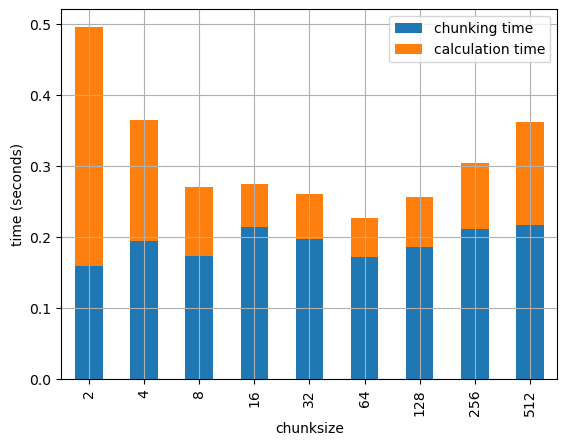

In [27]:
da = vpd[:, :200, :200] # taking a smaller slice of the array so that the calculation is faster

def calculate_mean(da, chunksize):

    # time the chunking overhead
    start = time.time()
    da = da.chunk({'time':chunksize})
    end = time.time()
    chunking_time = end-start

    # time the actual calculation
    start = time.time()
    _ = da.mean(['latitude', 'longitude']).compute(num_workers=30, scheduler='threads')
    end = time.time()
    calculation_time = end-start

    return pd.Series(
        [chunking_time, calculation_time],
        index=['chunking time', 'calculation time']
                     )

results = pd.DataFrame()
for chunksize in [2,4,8,16,32,64,128, 256, 512]:
    results[chunksize] = calculate_mean(da, chunksize=chunksize)

results.T.plot.bar(grid=True, xlabel='chunksize', ylabel='time (seconds)',
                   stacked=True)

In this case the optimum chunksize seems to be around 64. The chunking time does not seem to vary much, but the calculation time does.
Let's try the same thing chunking across lat/lon

<Axes: xlabel='chunksize', ylabel='time (seconds)'>

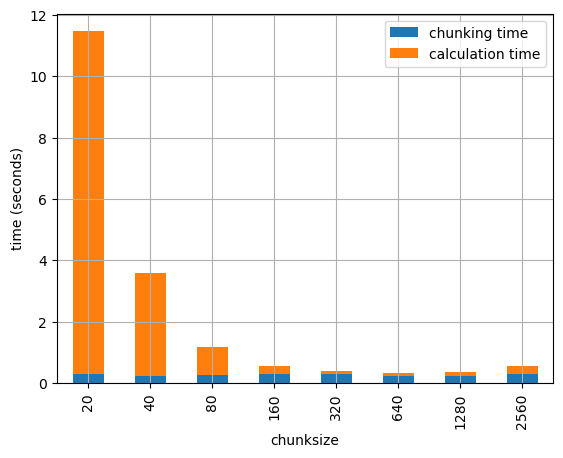

In [29]:
da = vpd[:10] # taking a smaller slice of the array so that the calculation is faster

def calculate_mean(da, chunksize):

    # time the chunking overhead
    start = time.time()
    da = da.chunk({'latitude':chunksize, 'longitude':chunksize})
    end = time.time()
    chunking_time = end-start

    # time the actual calculation
    start = time.time()
    _ = da.mean(['time']).compute(num_workers=30, scheduler='threads')
    end = time.time()
    calculation_time = end-start

    return pd.Series(
        [chunking_time, calculation_time],
        index=['chunking time', 'calculation time']
                     )

results = pd.DataFrame()
for chunksize in [20,40,80,160,320,640,1280, 2560]:
    results[chunksize] = calculate_mean(da, chunksize=chunksize)

results.T.plot.bar(grid=True, xlabel='chunksize', ylabel='time (seconds)',
                   stacked=True)

In this case it seems that larger chunks give a much better performance, with 640 being optimum. You can also chunk by setting the total number of chunks or letting dask choose the number of chunks with `chunks='auto'`

auto
600
300
150
75
36
18


<Axes: xlabel='chunksize', ylabel='time (seconds)'>

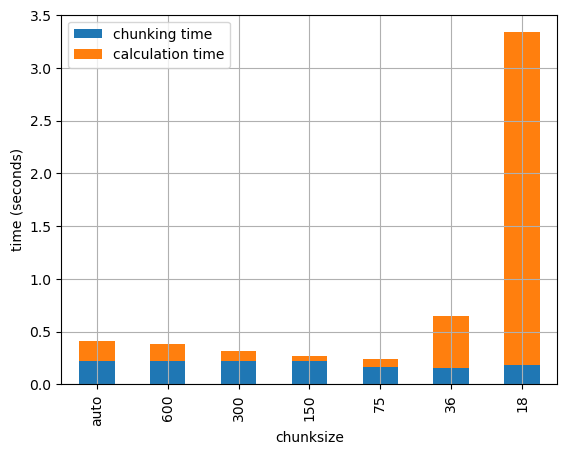

In [43]:
da = vpd[:, :200, :200] # taking a smaller slice of the array so that the calculation is faster

def calculate_mean(da, chunksize):

    # time the chunking overhead
    start = time.time()
    da = da.chunk(chunksize)
    end = time.time()
    chunking_time = end-start

    # time the actual calculation
    start = time.time()
    _ = da.mean(['latitude', 'longitude']).compute(num_workers=30, scheduler='threads')
    end = time.time()
    calculation_time = end-start

    return pd.Series(
        [chunking_time, calculation_time],
        index=['chunking time', 'calculation time']
                     )


results = pd.DataFrame()
for chunksize in ['auto',600, 300,150,75,36,18]:
    print(chunksize)
    results[chunksize] = calculate_mean(da, chunksize=chunksize)

results.T.plot.bar(grid=True, xlabel='chunksize', ylabel='time (seconds)',
                   stacked=True)

But it looks like 'auto' isn't always the best! 